In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import matplotlib.patches as mpatches

# Import Data

In [3]:
path_to_protest_data = "./local/data/"
raw_data_filename = "data.csv"
protests = pd.read_csv(path_to_protest_data+raw_data_filename)
protests.shape

(12652, 25)

# Transform

In [4]:
protests['accomodation'] = protests[[col for col in protests.columns if 'stateresponse' in col]].apply(
    lambda row: int(any(
        'accomodation' in str(val) for val in row)
        ), axis=1)
protests['stateviolence'] = protests[[col for col in protests.columns if 'stateresponse' in col]].apply(
    lambda row: int(any(
        any(
            keyword in str(val)
            for keyword in ['arrests', 'beatings', 'crowd dispersal', 'shootings', 'killings'])
        for val in row)
        ), axis=1)
protests['libdem'] = protests[['Electoral_Score', 'Liberal_Score', 'Participatory_Score', 'Deliberative_Score', 'Egalitarian_Score']].mean(axis=1)

In [5]:
transformed_filename = "full.csv"
protests.to_csv(path_to_protest_data+transformed_filename)

In [6]:
protests.head()

,id,Country,Year,region,protest,protesterviolence,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,...,Liberal_Score,Participatory_Score,Deliberative_Score,Egalitarian_Score,HDI_Score,violenceStatus,predicted_prob,accomodation,stateviolence,libdem
0,201990001,Canada,1990,North America,1,0,"political behavior, process",labor wage dispute,NaN,NaN,...,0.759,0.58,0.756,0.719,0.85,0,0.299385,0,0,0.7296
1,201990002,Canada,1990,North America,1,0,"political behavior, process",NaN,NaN,NaN,...,0.759,0.58,0.756,0.719,0.85,0,0.299385,0,0,0.7296
2,201990003,Canada,1990,North America,1,0,"political behavior, process",NaN,NaN,NaN,...,0.759,0.58,0.756,0.719,0.85,0,0.299385,0,0,0.7296
3,201990004,Canada,1990,North America,1,1,land farm issue,NaN,NaN,NaN,...,0.759,0.58,0.756,0.719,0.85,1,0.299385,1,0,0.7296
4,201990005,Canada,1990,North America,1,1,"political behavior, process",NaN,NaN,NaN,...,0.759,0.58,0.756,0.719,0.85,1,0.299385,1,1,0.7296


In [8]:
protests['Country'].value_counts()

Country
United Kingdom    574
France            542
Ireland           431
Germany           362
Kenya             350
                 ... 
Luxembourg          3
Eritrea             3
Bhutan              2
Qatar               1
South Sudan         1
Name: count, Length: 132, dtype: int64

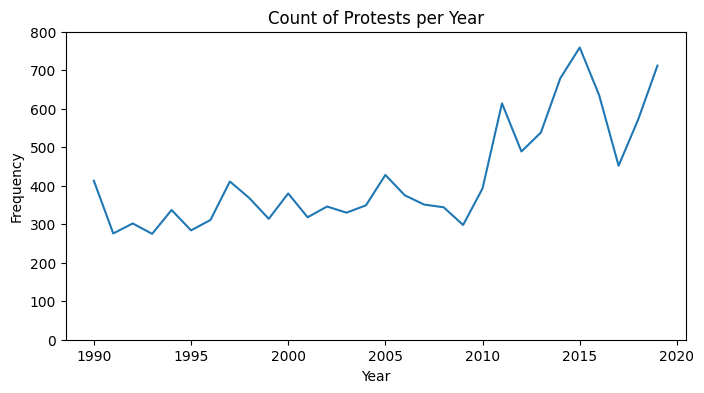

In [30]:
protests['Year'].value_counts().sort_index().plot.line(
    title='Count of Protests per Year',
    ylim = (0,800),
    ylabel = 'Frequency',
    figsize = (8,4))
plt.savefig('./output/images/year_dist.jpg')

In [37]:
(protests.query('Year <= 2010')['Year'].value_counts().mean(),
protests.query('Year > 2010')['Year'].value_counts().mean())

(343.0, 605.4444444444445)

In [120]:
protests['Year'].describe()

count    12652.000000
mean      2006.626620
std          8.812148
min       1990.000000
25%       1999.000000
50%       2008.000000
75%       2014.000000
max       2019.000000
Name: Year, dtype: float64

<Axes: xlabel='region'>

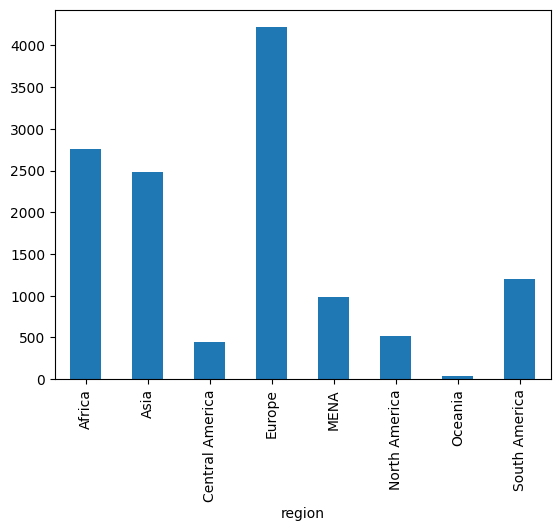

In [121]:
protests['region'].value_counts().sort_index().plot.bar()

In [122]:
protests[['protesterviolence','violenceStatus', 'stateviolence', 'accomodation']].agg(['sum','mean'])

,protesterviolence,violenceStatus,stateviolence,accomodation
sum,3340.00000,5575.000000,5102.000000,1302.000000
mean,0.26399,0.440642,0.403256,0.102909


In [123]:
(protests[['protesterviolence','stateviolence']].value_counts()/len(protests.index))

protesterviolence  stateviolence
0                  0                0.559358
1                  1                0.226604
0                  1                0.176652
1                  0                0.037385
Name: count, dtype: float64

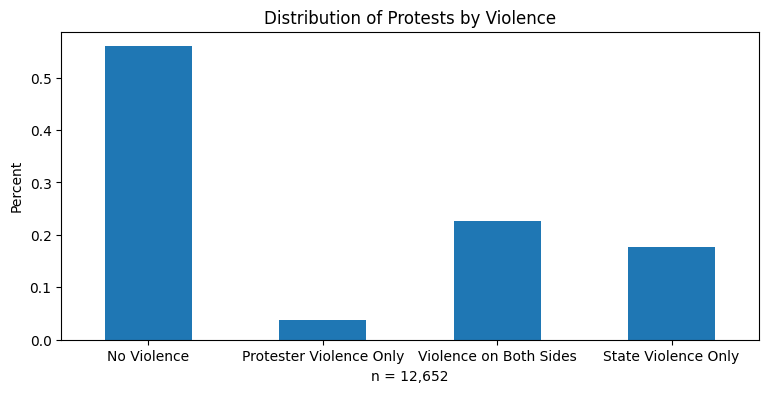

In [117]:
protests['violence'] = ''
protests.loc[protests['violenceStatus']==0, 'violence'] = 'No Violence'
protests.loc[(protests['stateviolence']==0) & (protests['protesterviolence']==1), 'violence'] = 'Protester Violence Only'
protests.loc[(protests['stateviolence']==1) & (protests['protesterviolence']==1), 'violence'] = 'Violence on Both Sides'
protests.loc[(protests['stateviolence']==1) & (protests['protesterviolence']==0), 'violence'] = 'State Violence Only'

plt.figure(figsize=(9,4))
protests['violence'].value_counts(normalize=True).reindex(['No Violence', 'Protester Violence Only', 'Violence on Both Sides', 'State Violence Only']).plot.bar()
plt.xticks(rotation=0)
plt.title('Distribution of Protests by Violence')
plt.ylabel('Percent')
plt.xlabel(f'n = {len(protests.index):,}')
plt.savefig('./output/images/violence_dist.jpg')

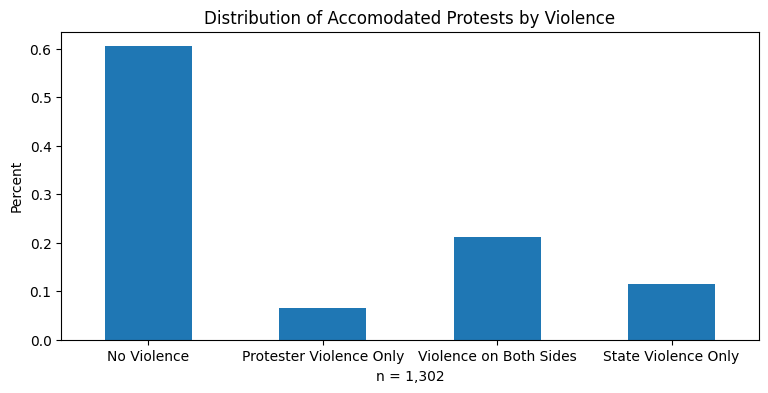

In [118]:
plt.figure(figsize=(9,4))
protests.loc[protests['accomodation']==1, 'violence'].value_counts(normalize=True).reindex(['No Violence', 'Protester Violence Only', 'Violence on Both Sides', 'State Violence Only']).plot.bar()
plt.xticks(rotation=0)
plt.title('Distribution of Accomodated Protests by Violence')
plt.ylabel('Percent')
plt.xlabel(f"n = {protests['accomodation'].sum():,}")
plt.savefig('./output/images/violence_dist_2.jpg')

In [86]:
# fig, ax = plt.subplots(figsize=(8, 6))

# bars = ax.bar(protests['violence'].value_counts().index, protests['violence'].value_counts().values, label='Total in Category')

# for i, bar in enumerate(bars):
#     if protests['violence'].value_counts().index[i] == 'Protester Violence':  
#         ax.bar(bar.get_x() + bar.get_width()/2, height=((protests['stateviolence']==1) & (protests['protesterviolence']==1)).sum(), 
#                width=bar.get_width(), bottom=0, label='Met with State Violence')
        
# # Customize the plot
# ax.set_ylabel('Count')
# ax.set_title('Protests by Instigators of Violence')
# ax.legend()

# # Show the plot
# plt.tight_layout()
# plt.show()

In [116]:
protests['protesterdemand1'].value_counts()

protesterdemand1
political behavior, process    7964
labor wage dispute             1421
price increases, tax policy     966
removal of politician           848
police brutality                657
land farm issue                 409
social restrictions             386
Name: count, dtype: int64

In [ ]:
protests['stateresponse1'].value_counts()

stateresponse1
ignore             6841
crowd dispersal    3313
arrests             874
accomodation        830
shootings           366
killings            219
beatings            186
Name: count, dtype: int64

In [119]:
protests[['libdem','Electoral_Score', 'Liberal_Score', 'Participatory_Score', 'Deliberative_Score', 'Egalitarian_Score','HDI_Score']].corr(method='pearson').round(2)

,libdem,Electoral_Score,Liberal_Score,Participatory_Score,Deliberative_Score,Egalitarian_Score,HDI_Score
libdem,1.00,0.99,0.99,0.99,0.99,0.98,0.65
Electoral_Score,0.99,1.00,0.98,0.98,0.96,0.94,0.60
Liberal_Score,0.99,0.98,1.00,0.98,0.98,0.97,0.65
Participatory_Score,0.99,0.98,0.98,1.00,0.96,0.95,0.63
Deliberative_Score,0.99,0.96,0.98,0.96,1.00,0.95,0.62
Egalitarian_Score,0.98,0.94,0.97,0.95,0.95,1.00,0.71
HDI_Score,0.65,0.60,0.65,0.63,0.62,0.71,1.00


In [ ]:
# protests.groupby('Country')['predicted_prob'].mean().sort_values(ascending=False)

# Summary by Region

In [11]:
protests['region'].value_counts(normalize=True)

region
Europe             0.333386
Africa             0.218226
Asia               0.196412
South America      0.094531
MENA               0.077695
North America      0.041100
Central America    0.035647
Oceania            0.003003
Name: proportion, dtype: float64

In [222]:
protests.groupby('region')["violence"].value_counts(normalize=True).reset_index().pivot(index='region', columns='violence').apply(zscore)

proportion                                              \
violence        No Violence Protester Violence Only State Violence Only   
region                                                                    
Africa            -1.398355                0.225650            0.565659   
Asia              -0.425864               -0.469199            0.228287   
Central America    0.198344                1.051892           -0.841181   
Europe             1.760410               -0.904261           -0.919495   
MENA              -1.360097               -0.850542            2.047512   
North America     -0.027838                1.909435           -0.285876   
Oceania            0.416092                0.215559           -1.259105   
South America      0.837308               -1.178533            0.464199   

                                        
violence        Violence on Both Sides  
region                                  
Africa                        1.609278  
Asia                          0.697365  
Central America               0.098151  
Europe                       -1.474740  
MENA                          0.386392  
North America                -0.588568  
Oceania                       0.630748  
South America                -1.358625

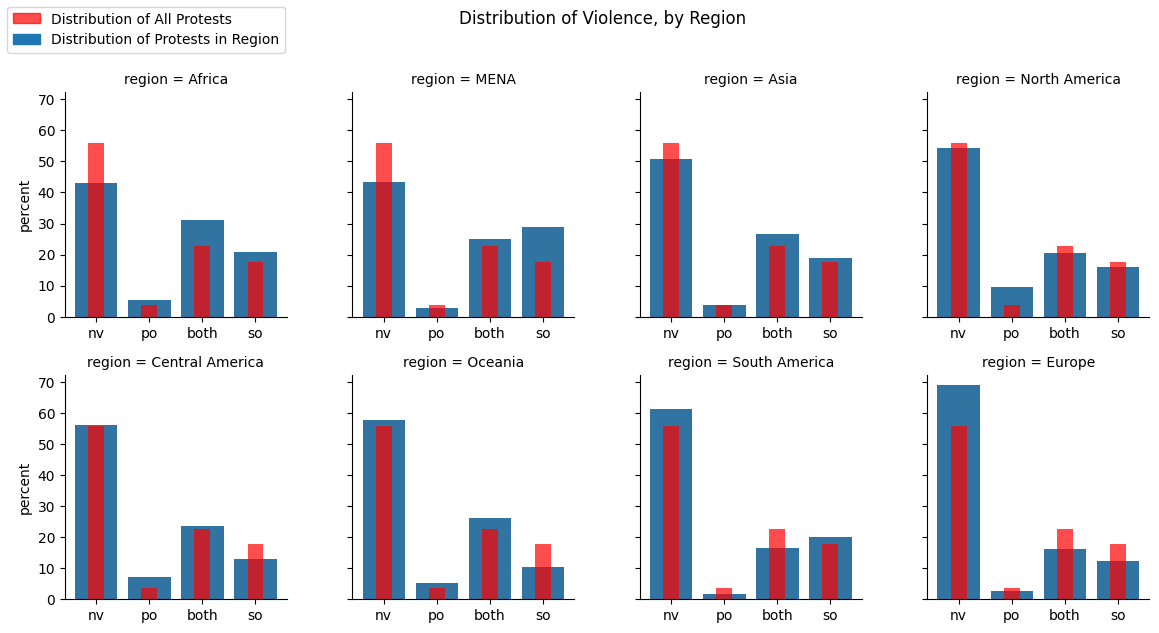

In [199]:
g = sns.FacetGrid(protests, col="region", col_wrap=4, sharex=False, col_order=protests.groupby('region')['violenceStatus'].mean().sort_values(ascending=False).index)  
g.map(sns.countplot, "violence", order=['No Violence', 'Protester Violence Only', 'Violence on Both Sides', 'State Violence Only'], stat='percent')
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_xticks(range(4))
    ax.set_xticklabels(['nv','po','both','so'])
    ax.bar(range(4), 100*protests['violence'].value_counts(normalize=True).reindex(['No Violence', 'Protester Violence Only', 'Violence on Both Sides', 'State Violence Only']), alpha=0.7, color='red', width=0.3)

g.figure.suptitle("Distribution of Violence, by Region", y=1.08)
g.figure.legend(handles=[
    mpatches.Patch(color="red", alpha=0.7, label="Distribution of All Protests"),
    mpatches.Patch(color=sns.color_palette()[0], label="Distribution of Protests in Region")
], loc="upper left")

plt.savefig('./output/images/violence_region3.jpg', bbox_inches="tight")

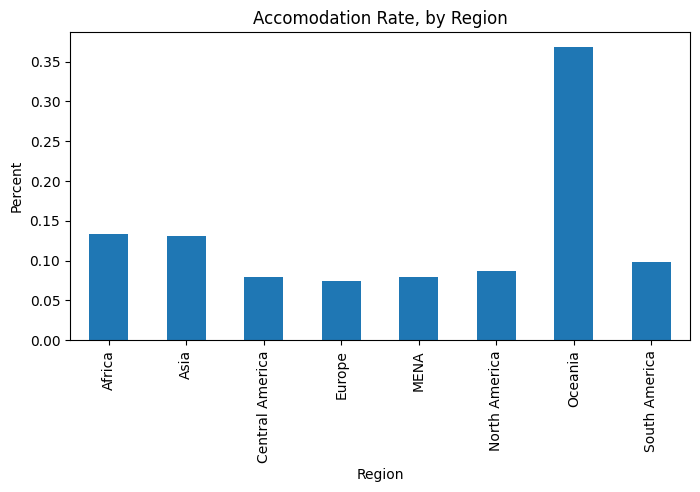

In [212]:
protests.groupby('region')[['accomodation']].mean().plot.bar(legend=False)
plt.title("Accomodation Rate, by Region")
plt.ylabel('Percent')
plt.xlabel('Region')
plt.gcf().set_size_inches(8,4)
plt.savefig('./output/images/accomodation2.jpg', bbox_inches="tight")